In [1]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
import re
import json
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import string

# Configuration

In [2]:
class Config:
    CLS = [101]
    SEP = [102]
    VALUE_TOKEN = [0]
    MAX_LEN = 512
    TRAIN_BATCH_SIZE = 5
    VAL_BATCH_SIZE = 5
    EPOCHS = 8
    DROPOUT = 0.35
    TOKENIZER = AutoTokenizer.from_pretrained('dslim/bert-base-NER', do_lower_case=False, model_max_length=512)
    
device =  "cuda" if torch.cuda.is_available() else "cpu"

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Data Preprocessing
#### The goal is to convert the JSON file to a data frame that will hold arrays of words and tags respectively.
#### Steps: 
1. Convert text to spacy format
2. Remove stopwords and non-alphanumeric words, while mapping identified entities to their respective labels
3. Encode tags
4. Group By Sentences

In [3]:
#Load File
data = pd.read_json("../input/resume-entities-for-ner/Entity Recognition in Resumes.json", lines = True)
data.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [4]:
def convert_and_trim_data_to_spacy(JSON_FilePath):
    training_data = []
    invalid_span_tokens = re.compile(r'\s')

    with open(JSON_FilePath, 'r') as f:
        for line in f:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []

            if data.get('annotation'):
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    labels = labels if isinstance(labels, list) else [labels]

                    # Adjust the start and end points based on leading/trailing spaces
                    point_text = point['text']
                    point_start = point['start'] + len(point_text) - len(point_text.lstrip())
                    point_end = point['end'] - (len(point_text) - len(point_text.rstrip())) + 1

                    for label in labels:
                        # Trim leading spaces
                        valid_start = point_start
                        while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
                            valid_start += 1

                        # Trim trailing spaces
                        valid_end = point_end
                        while valid_end > valid_start and invalid_span_tokens.match(text[valid_end - 1]):
                            valid_end -= 1

                        entities.append((valid_start, valid_end, label))

            training_data.append((text, {"entities": entities}))
    
    return training_data


data = convert_and_trim_data_to_spacy("../input/resume-entities-for-ner/Entity Recognition in Resumes.json")
data[0]

("Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [5]:
# Set of English stopwords
en_stops = set(stopwords.words('english'))

# Initialize the DataFrame
df_data = pd.DataFrame(columns=["clean_content", "entities_mapped"])

entities_mapped = []
clean_content = []

for content, meta in data:
    words = []
    labels = []
    entities = meta["entities"]

    for word in content.split():
        # Check if the word is valid and not a stop word
        if (word.isalnum() or ".com" in word) and word not in en_stops:
            words.append(word)
            # Initialize the label as "O" (for non-entities)
            label = "O"
            # Check for entities
            for ent_start, ent_end, ent_label in sorted(entities):
                if word in content[ent_start:ent_end].split():
                    label = ent_label
                    break
            labels.append(label)
    
    entities_mapped.append(labels)
    clean_content.append(" ".join(words))

# Update DataFrame
df_data["entities_mapped"] = entities_mapped
df_data["clean_content"] = clean_content

In [6]:
# Create an empty list to hold the new rows
formatted_data = []

# Loop through the DataFrame to build the new format
for sentence_number, (content, labels) in enumerate(zip(df_data["clean_content"], df_data["entities_mapped"]), start=1):
    words = content.split()
    
    # Ensure the number of words matches the number of labels
    for word, tag in zip(words, labels):
        formatted_data.append({
            "Document #": f"Document: {sentence_number}",
            "Word": word,
            "Tag": tag
        })

# Create a new DataFrame from the formatted data
df_data = pd.DataFrame(formatted_data)

# Display the formatted DataFrame
df_data.head()

,Document #,Word,Tag
0,Document: 1,Abhishek,Name
1,Document: 1,Jha,Name
2,Document: 1,Application,Designation
3,Document: 1,Development,Designation
4,Document: 1,Associate,Designation


In [7]:
#Checking Missing Values
df_data.isna().sum(axis=0)

Document #    0
Word          0
Tag           0
dtype: int64

In [8]:
#Tag Label Counts
df_data.Tag.value_counts()

O                      52387
Skills                  5220
Designation             1979
Companies worked at     1444
College Name            1042
Degree                   775
Name                     470
Graduation Year          249
Email Address            212
Location                 103
Years of Experience       81
UNKNOWN                    1
Name: Tag, dtype: int64

In [9]:
#Filling Missing Values and Label Encoding
le = LabelEncoder().fit(df_data['Tag'])
df_data['Tag'] = le.transform(df_data['Tag'])
df_data.head()

,Document #,Word,Tag
0,Document: 1,Abhishek,7
1,Document: 1,Jha,7
2,Document: 1,Application,3
3,Document: 1,Development,3
4,Document: 1,Associate,3


In [10]:
#Group By Sentences
data_gr = df_data.groupby("Document #").agg({'Word': list, 'Tag':list})
final_data_gr = data_gr.copy()
print("Sentences in data:", len(data_gr))
data_gr.head()

Sentences in data: 220


,Word,Tag
Document #,,
Document: 1,"[Abhishek, Jha, Application, Development, Asso...","[7, 7, 3, 3, 3, 1, 8, 8, 4, 8, 8, 8, 8, 8, 8, ..."
Document: 10,"[Ashok, Kunam, Team, Lead, Microsoft, Email, i...","[7, 7, 3, 3, 1, 8, 4, 9, 8, 8, 8, 8, 8, 8, 8, ..."
Document: 100,"[Vikas, Singh, Chandigarh, Email, indeed.com/r...","[7, 7, 6, 8, 4, 8, 8, 8, 8, 8, 0, 1, 8, 8, 8, ..."
Document: 101,"[Yasothai, Jayaramachandran, Lead, Engineer, A...","[7, 7, 3, 3, 1, 1, 8, 8, 8, 4, 4, 11, 11, 8, 8..."
Document: 102,"[Yathishwaran, P, Maximo, Consultant, Infosys,...","[7, 7, 3, 3, 1, 1, 8, 8, 8, 4, 3, 3, 1, 8, 8, ..."


In [11]:
# Limit sentences
LIMIT = False
LIMIT_BY = 5000

if LIMIT:
    final_data_gr = data_gr.head(LIMIT_BY)

In [12]:
#Train Test Split
train_sent, val_sent, train_tag, val_tag = train_test_split(final_data_gr['Word'], final_data_gr['Tag'], test_size=0.15, random_state=10)
print("Train sentences: ",len(train_sent))
print("Validation sentences: ",len(val_sent))

Train sentences:  187
Validation sentences:  33


# Create DataSet

In [13]:
class Dataset:
    def __init__(self, texts, tags):
        self.texts = texts
        self.tags = tags
  
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        texts = self.texts[index]
        tags = self.tags[index]

        # Tokenize
        ids = []
        target_tag = []

        for i, s in enumerate(texts):
            inputs = Config.TOKENIZER.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend(input_len * [tags[i]])
        
        # To Add Special Tokens, subtract 2 from MAX_LEN
        ids = ids[:Config.MAX_LEN - 2]
        target_tag = target_tag[:Config.MAX_LEN - 2]

        # Add Special Tokens
        ids = Config.CLS + ids + Config.SEP
        target_tags = Config.VALUE_TOKEN + target_tag + Config.VALUE_TOKEN

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        # Add Padding if the input_len is small
        padding_len = Config.MAX_LEN - len(ids)
        ids = ids + ([0] * padding_len)
        target_tags = target_tags + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_tags": torch.tensor(target_tags, dtype=torch.long)
        }

In [14]:
# Create DataLoaders
train_dataset = Dataset(texts = train_sent, tags = train_tag)
val_dataset = Dataset(texts = val_sent, tags = val_tag)
train_dl = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=Config.VAL_BATCH_SIZE, pin_memory=True)

# Build a Model, Calculate Loss

In [15]:
class NERBertModel(nn.Module):
    
    def __init__(self, num_tag):
        super(NERBertModel, self).__init__()
        self.num_tag = num_tag
        model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
        model.dropout = torch.nn.Dropout(p=Config.DROPOUT)
        model.classifier = torch.nn.Linear(in_features=768, out_features=self.num_tag, bias=True)
        self.bert = model
        
    def forward(self, ids, mask, token_type_ids, target_tags=None):

        tag_logits = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)[0]
        
        loss = None
        if target_tags is not None:
            # Calculate the loss only if target tags are provided
            criterion_loss = nn.CrossEntropyLoss()
            
            # Flatten mask, logits, and target tags for loss calculation
            active_loss = mask.view(-1) == 1
            active_logits = tag_logits.view(-1, self.num_tag)
            
            # Ensure ignore index is on the same device
            ignore_index = torch.tensor(criterion_loss.ignore_index).type_as(target_tags)
            active_labels = torch.where(active_loss, target_tags.view(-1), ignore_index)
            
            # Compute the loss
            loss = criterion_loss(active_logits, active_labels)
        
        return tag_logits, loss

# Training and Evaluation Functions

In [16]:
def train_and_validate(model, train_loader, validation_loader, optimizer, epochs=5, max_lr=0.01, train_loss_threshold=None, verbose=True):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False

    # Calculate the total number of steps in one cycle
    total_steps = epochs * len(train_loader)
    
    # Define the OneCycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)

    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break

        model.train()
        # Training loop
        for sample_batched in tqdm(train_loader, total=len(train_loader)):
            for indx, val in sample_batched.items():
                sample_batched[indx] = val.to(device)

            optimizer.zero_grad()
            _, loss = model(**sample_batched)
            
            if loss.ndimension() > 0:
                loss = loss.mean()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
            
            # Step the scheduler
            scheduler.step()
            lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            model.eval()
            for sample_batched in tqdm(validation_loader, total=len(validation_loader)):
                for indx, val in sample_batched.items():
                    sample_batched[indx] = val.to(device)

                _, val_loss = model(**sample_batched)
                
                if val_loss.ndimension() > 0:
                    val_loss = val_loss.mean()
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            if verbose:
                print("================================================================================")
                print(f"Epoch {e + 1} completed")
                print(f"Average train loss: {train_epoch_loss}")
                print(f"Average validation loss: {validation_epoch_loss}")
                print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train The Model

In [17]:
def get_parameters(model, full_finetuning):
    if full_finetuning:
        onedim_params = [p for p in model.parameters() if p.ndim == 1]
        other_params = [p for p in model.parameters() if p.ndim != 1]
    else:
        onedim_params = [p for p in model.bert.classifier.parameters() if p.ndim == 1]
        other_params = [p for p in model.bert.classifier.parameters() if p.ndim != 1]

    parameters = [
        {'params': other_params},
        {'params': onedim_params, 'weight_decay': 0}
    ]
    
    return parameters

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

  0%|          | 0/38 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Epoch 1 completed
Average train loss: 1.8355866200045536
Average validation loss: 0.8272095748356411


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Epoch 2 completed
Average train loss: 0.8071886944143396
Average validation loss: 0.505521148443222


100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Epoch 3 completed
Average train loss: 0.5270619251226124
Average validation loss: 0.4036694977964674


100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Epoch 4 completed
Average train loss: 0.3944405419261832
Average validation loss: 0.35781311988830566


100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


Epoch 5 completed
Average train loss: 0.31118060217091914
Average validation loss: 0.34309664368629456


100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


Epoch 6 completed
Average train loss: 0.27039889363866104
Average validation loss: 0.35254427790641785


100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch 7 completed
Average train loss: 0.24042760659205287
Average validation loss: 0.3305576762982777


100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


Epoch 8 completed
Average train loss: 0.2219451160023087
Average validation loss: 0.3325326996190207


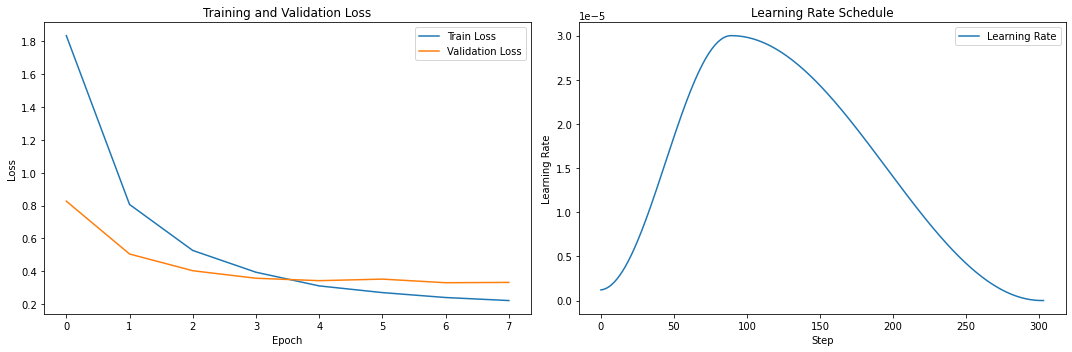

In [18]:
# Define your hyperparameters
epochs = Config.EPOCHS
learning_rate = 0.00003
weight_decay = 0.005

# Load pre-trained model
num_tag = len(df_data.Tag.value_counts())
model = NERBertModel(num_tag=num_tag)
model.to(device)

optimizer_params = get_parameters(model, True)

full_opt = optim.AdamW(optimizer_params, lr=learning_rate/10, weight_decay=weight_decay)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

train_and_validate(model, train_dl, val_dl, full_opt, epochs, learning_rate)

# Prediction

In [19]:
def prediction(test_sentence, model, le, max_rows=None):
    # Add spaces before punctuation
    for i in list(string.punctuation):
        test_sentence = test_sentence.replace(i, ' ' + i)

    # Split the sentence into words
    words = test_sentence.split()

    # Tokenize each word individually
    Token_inputs = []
    for word in words:
        tokenized_word = Config.TOKENIZER.encode(word, add_special_tokens=False)
        Token_inputs.append(tokenized_word)

    # Create dataset with the tokens
    test_dataset = Dataset([words], tags=[[1] * len(words)])
    num_tag = len(le.classes_)

    with torch.no_grad():
        data = test_dataset[0]
        for i, j in data.items():
            data[i] = j.to(device).unsqueeze(0)

        # Get model predictions
        tag, _ = model(**data)

        # Get predicted tags and map to label names
        predicted_tags = le.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))[1:len(Token_inputs)+1]
        
    # Assign 'O' to stopwords and non-alphanumeric words
    for i in range(len(words)):
        if words[i] in en_stops or not words[i].isalnum():
            predicted_tags[i] = "O"

    # Limit rows displayed based on max_rows
    if max_rows is not None:
        words = words[:max_rows]
        predicted_tags = predicted_tags[:max_rows]

    # Print results in a tabular format
    print("\nWord-Prediction Pairs:")
    print("-" * 30)
    for word, pred_tag in zip(words, predicted_tags):
        print(f"{word:<15} -> {pred_tag}")
    print("-" * 30)
    
    # Optionally print if there are more rows
    if max_rows and len(test_sentence.split()) > max_rows:
        print(f"...and {len(test_sentence.split()) - max_rows} more rows.")

In [20]:
#test_sentence = ' '.join(val_dataset.texts[0])
test_sentence = "Abhishek Jha Application Development Associate - Accenture Bengaluru, Karnataka."
prediction(test_sentence, model, le, 30)


Word-Prediction Pairs:
------------------------------
Abhishek        -> Name
Jha             -> Name
Application     -> Name
Development     -> Name
Associate       -> Name
-               -> O
Accenture       -> Name
Bengaluru       -> Designation
,               -> O
Karnataka       -> Designation
.               -> O
------------------------------


In [21]:
tag_names = le.classes_
print(tag_names)
tag_labels = le.transform(tag_names)
print(tag_labels)

['College Name' 'Companies worked at' 'Degree' 'Designation'
 'Email Address' 'Graduation Year' 'Location' 'Name' 'O' 'Skills'
 'UNKNOWN' 'Years of Experience']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


# Evaluation

In [22]:
# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Validation loop
with torch.no_grad():
    model.eval()
    for sample_batched in tqdm(val_dl, total=len(val_dl)):
        for indx, val in sample_batched.items():
            sample_batched[indx] = val.to(device)
        
        # Get model output (logits) and loss
        tag_logits, _ = model(**sample_batched)
        
        # Get predictions by taking the argmax of the logits along the last dimension (tags dimension)
        pred_tags = torch.argmax(tag_logits, dim=-1)
        
        # Flatten the mask and apply it to the labels and predictions to ignore padding tokens
        active_mask = sample_batched['mask'].view(-1) == 1  # Get the active tokens
        active_pred_tags = pred_tags.view(-1)[active_mask]   # Only keep predictions for non-padding tokens
        active_true_tags = sample_batched['target_tags'].view(-1)[active_mask]  # True tags without padding
        
        # Append predictions and true labels to lists
        all_preds.extend(active_pred_tags.cpu().numpy())
        all_labels.extend(active_true_tags.cpu().numpy())

# Identify present labels
present_labels = list(set(all_labels) & set(all_preds))

# Filter out labels not in tag_labels
valid_labels = [label for label in present_labels if label in tag_labels]

# Create a filtered version of tag_names and tag_labels
filtered_tag_names = [tag_names[i] for i, label in enumerate(tag_labels) if label in valid_labels]
filtered_tag_labels = [label for label in tag_labels if label in valid_labels]

# Generate classification report with the filtered labels
report = classification_report(
    all_labels,
    all_preds,
    target_names=filtered_tag_names,
    labels=filtered_tag_labels,
)
print(report)

# Optionally, calculate F1 score for a specific average
f1 = f1_score(all_labels, all_preds, labels=filtered_tag_labels, average='weighted')
print(f"F1 Score (weighted): {f1}")

100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                     precision    recall  f1-score   support

       College Name       0.64      0.76      0.69       205
Companies worked at       0.62      0.71      0.66       324
             Degree       0.80      0.38      0.52       115
        Designation       0.70      0.67      0.68       462
      Email Address       0.85      1.00      0.92       621
               Name       0.92      0.96      0.94       184
                  O       0.94      0.95      0.95     11500
             Skills       0.65      0.37      0.47       645

          micro avg       0.90      0.91      0.90     14056
          macro avg       0.76      0.72      0.73     14056
       weighted avg       0.90      0.91      0.90     14056

F1 Score (weighted): 0.900002444322726
